In [1]:
from utils import * 
from algorithms import *
from agents import *

In [2]:
numRounds, numPeriods, numSteps = 1, 10000, 10
numBuyers, numSellers, numTokens = 4, 4, 4
gameTypes, seed = '1111', 42
disclosure = ['bids', 'asks', 'currentBid', 'currentBidIdx','currentAsk', 'currentAskIdx', 'buy', 'sell', 'price', 'sale']
depth = 1
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
verbose = 1
numStates = 18
numActions = 50
episodeLength = 10
epsilon_decay = 0.99995
buyers = [Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, numStates = 2, algo='VPG',
                     algoArgs = [numStates, episodeLength, numActions]),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0)]
sellers = [ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)]
log = Log(gameData, disclosure)
rnd = 0

In [3]:
print_interval = 1
for rnd in range(numRounds):
    startRounds(gameData, log, buyers, sellers, rnd)
    #print(log.roundData.buyerValues.item())
    score1, score2 = 0.0, 0.0
    ss1, ss2 = 0.0, 0.0
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        period_bids = []
        for step in range(numSteps):
            # start
            startSteps(buyers, sellers)

            # set state
            buyers[0].state = generateState(buyers[0], disclosure, depth)

            # trade
            bids, asks = collectOffers(buyers, sellers)
            period_bids.append(np.round(bids[0],1))
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits
            if currentBidIdx == 0:
                score1 += bprofit
                ss1 += bprofit
            elif currentBidIdx == 1:
                score2 += bprofit
                ss2 += bprofit
                
            log.addStep([rnd, period, step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers) # updates period counters

            buyers[0].newState  = generateState(buyers[0], disclosure, depth)

            if step == numSteps - 1:
                buyers[0].done = True
            else:
                buyers[0].done = False

            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)

        endPeriods(buyers, sellers)

        if period%100==0:
            print('\t',ss1/100, ss2/100,  period_bids)
            ss1 = 0
            ss2 = 0
        if period%print_interval==0:
            print(step, round(score1 / print_interval, 2), round(score2 / 100, 2), np.round(buyers[0].algo.epsilon,2), period_bids)
            score1 = 0.0
            score2 = 0.0
    endRounds(buyers, sellers)

9 59.11 0.69 0.01 [85.5, 88.9, 84.4, 59.7, 76.5, 51.8, 82.1, nan, nan, nan]
9 69.94 0.53 0.01 [86.6, 78.8, 70.9, 65.3, 68.7, 88.9, 57.4, 86.6, nan, nan]
9 61.12 0.73 0.01 [76.5, 65.3, 76.5, 68.7, 59.7, 58.6, 75.4, 64.2, 84.4, 59.7]
9 45.18 0.53 0.01 [59.7, 79.9, 40.6, 63.1, 83.3, 36.1, 54.1, 40.6, 39.5, 86.6]
9 58.73 0.59 0.01 [73.2, 84.4, 76.5, 88.9, 88.9, nan, nan, nan, nan, nan]
9 81.05 0.51 0.01 [54.1, 63.1, 85.5, 46.2, 78.8, 59.7, 69.8, nan, nan, nan]
9 66.31 0.23 0.01 [90.0, 76.5, 42.9, 83.3, 76.5, 81.0, nan, nan, nan, nan]
9 65.27 0.37 0.01 [79.9, 55.2, 59.7, 66.4, 67.6, 84.4, 87.8, nan, nan, nan]
9 62.11 0.56 0.01 [54.1, 68.7, 77.7, 88.9, 84.4, 79.9, nan, nan, nan, nan]
9 55.52 0.63 0.01 [76.5, 88.9, 59.7, 65.3, 83.3, 56.3, 38.4, 86.6, nan, nan]
9 64.45 0.62 0.01 [50.7, 76.5, 79.9, 39.5, 70.9, 65.3, 84.4, 85.5, nan, nan]
9 52.54 0.49 0.01 [84.4, 59.7, 77.7, 79.9, 70.9, 65.3, 47.3, 79.9, 39.5, 88.9]
9 65.44 0.36 0.01 [76.5, 75.4, 79.9, 84.4, 82.1, nan, nan, nan, nan, nan]
9 68.7

KeyboardInterrupt: 

In [ ]:
a = (torch.tensor(buyers[0].state )-buyers[0].algo.state_mean)/(torch.sqrt(buyers[0].algo.state_std))
formatted_elements = [f'{val:.4f}' for val in a.tolist()]
formatted_tensor = "[" + ", ".join(formatted_elements) + "]"
print(formatted_tensor)

In [ ]:
(torch.tensor(buyers[0].state )-buyers[0].algo.state_mean)/(torch.sqrt(buyers[0].algo.state_std))

In [ ]:
log.getPeriod(0,6)

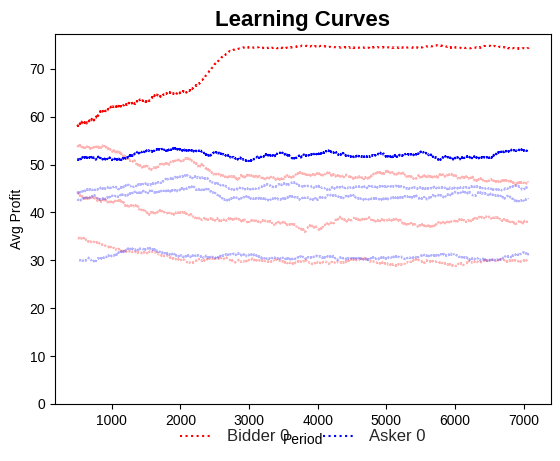

In [4]:
log.graphLearning(rolling_window = 500, trackBuyersIdx=[0], trackSellersIdx=[0])

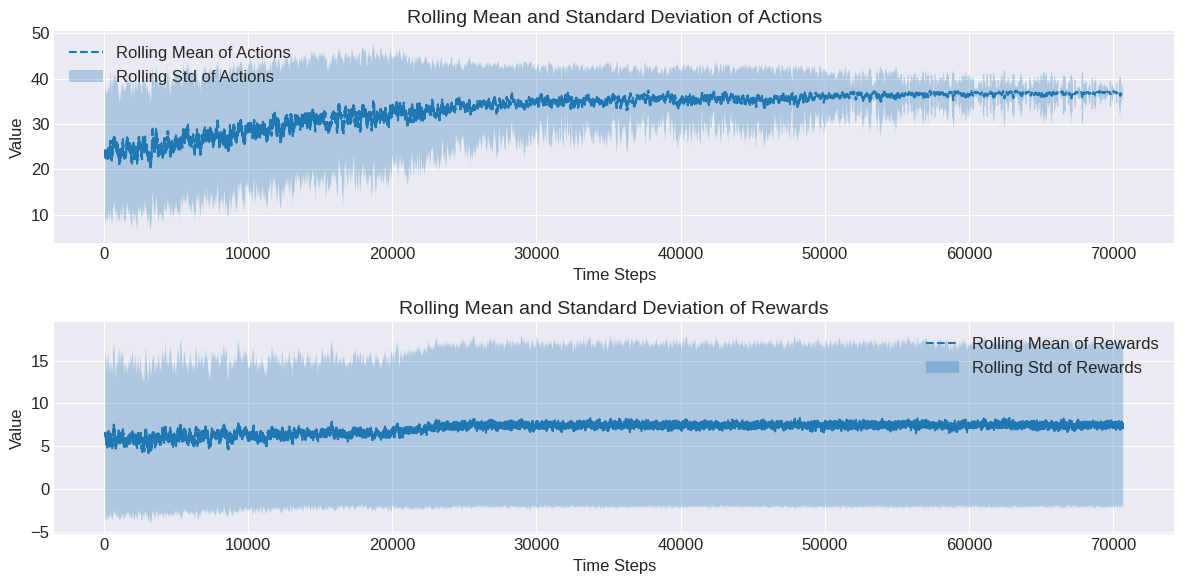

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'memory' contains your data
memory = pd.DataFrame(buyers[0].algo.memory, columns=['state', 'action', 'reward', 'newState', 'done'])

# Calculate the rolling mean and standard deviation for actions and rewards
window_size = 100  # You can adjust the window size as needed
rolling_action_mean = memory['action'].rolling(window=window_size).mean()
rolling_reward_mean = memory['reward'].rolling(window=window_size).mean()
rolling_action_std = memory['action'].rolling(window=window_size).std()
rolling_reward_std = memory['reward'].rolling(window=window_size).std()

# Plot the rolling means and standard deviations separately for actions and rewards
plt.figure(figsize=(12, 6))

# Plot Rolling Mean and Std for Actions
plt.subplot(2, 1, 1)
plt.plot(rolling_action_mean, label='Rolling Mean of Actions')
plt.fill_between(
    range(len(memory)),
    rolling_action_mean - rolling_action_std,
    rolling_action_mean + rolling_action_std,
    alpha=0.3,
    label='Rolling Std of Actions'
)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.title('Rolling Mean and Standard Deviation of Actions')

# Plot Rolling Mean and Std for Rewards
plt.subplot(2, 1, 2)
plt.plot(rolling_reward_mean, label='Rolling Mean of Rewards')
plt.fill_between(
    range(len(memory)),
    rolling_reward_mean - rolling_reward_std,
    rolling_reward_mean + rolling_reward_std,
    alpha=0.3,
    label='Rolling Std of Rewards'
)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.title('Rolling Mean and Standard Deviation of Rewards')

plt.tight_layout()
plt.show()


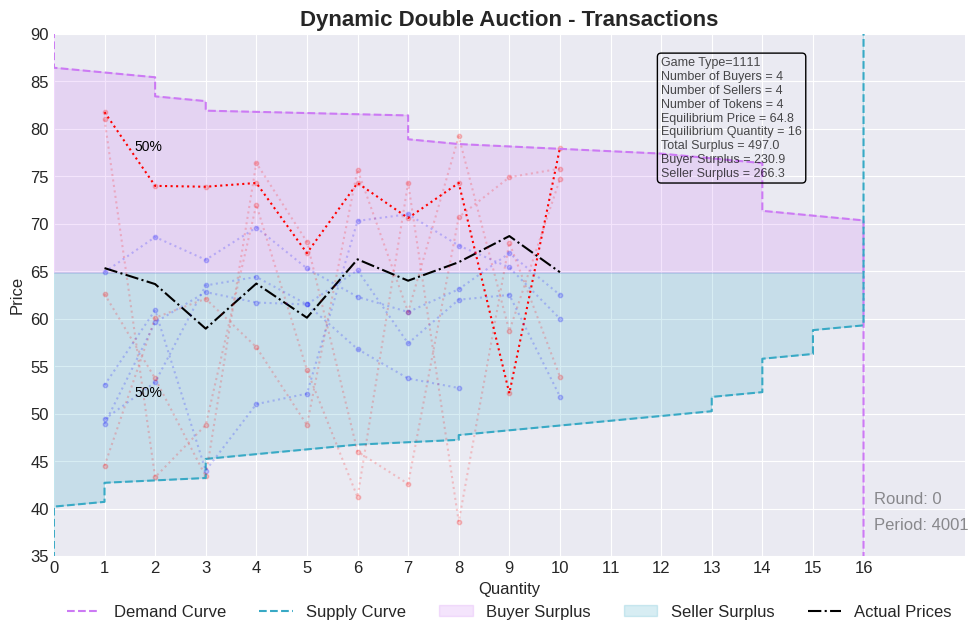

In [7]:
log.graphSales(0, period-8, trackBuyersIdx=[0], trackSellersIdx=[])

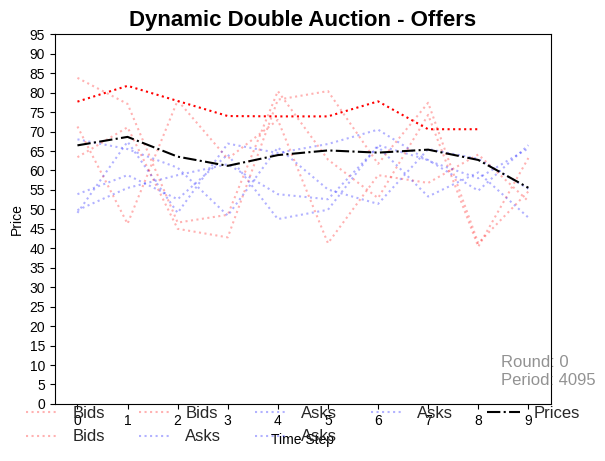

In [15]:
log.graphOffers(0, period-1, trackBuyersIdx=[0], trackSellersIdx=[])

In [17]:
log.graphTraining(maxNumPeriods=period-1, skip = int((period-1)/20), trackBuyersIdx = [0])